# Survival Analysis with Plotly in Python

## An introduction to survival analysis with Plotly graphs using R, Python, and IPython notebooks 

In this notebook, we introduce survival analysis and we show application examples using both R and Python. We will compare the two programming languages, and leverage Plotly's Python and R APIs to convert static graphics into interactive plotly objects.

[Plotly](https://plot.ly/) is a platform for making interactive graphs with R, Python, MATLAB, and Excel. You can make graphs and analyze data on Plotly’s free public cloud. For collaboration and sensitive data, you can run Plotly [on your own servers](https://plot.ly/product/enterprise/).

For a more in-depth theoretical background in survival analysis, please refer to these sources:

- [Lecture Notes by John Fox](http://socserv.mcmaster.ca/jfox/Courses/soc761/survival-analysis.pdf)
- [Wikipedia article](http://en.wikipedia.org/wiki/Survival_analysis)
- [Presentation by Kristin Sainani](https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/www.pitt.edu/~super4/33011-34001/33051-33061.ppt)
- [Lecture Notes by Germán Rodríguez](http://data.princeton.edu/wws509/notes/c7.pdf)

Need help converting Plotly graphs from R or Python?

- [R](https://plot.ly/r/user-guide/)
- [Python](https://plot.ly/python/matplotlib-to-plotly-tutorial/)

For this code to run on your machine, you will need several R and Python packages installed.

> Running `sudo pip install <package_name>` from your terminal will install a Python package.

> Running `install.packages("<package_name>")` in your R console will install an R package.

You will also need to create an account with [Plotly](https://plot.ly/feed/) to receive your API key.

## Initial setup

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load extension that let us use magic function `%R`
%load_ext rpy2.ipython

In [3]:
%%R

# show the path where the libraries are installed 
# note this path is different from the one in standalone RStudio
.libPaths()

[1] "/home/alvaro/anaconda2/lib/R/library"


In [4]:
%%R
?install.packages()

R Help on ‘install.packages’install.packages             package:utils             R Documentation

_I_n_s_t_a_l_l _P_a_c_k_a_g_e_s _f_r_o_m _R_e_p_o_s_i_t_o_r_i_e_s _o_r _L_o_c_a_l _F_i_l_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Download and install packages from CRAN-like repositories or from
     local files.

_U_s_a_g_e:

     install.packages(pkgs, lib, repos = getOption("repos"),
                      contriburl = contrib.url(repos, type),
                      method, available = NULL, destdir = NULL,
                      dependencies = NA, type = getOption("pkgType"),
                      configure.args = getOption("configure.args"),
                      configure.vars = getOption("configure.vars"),
                      clean = FALSE, Ncpus = getOption("Ncpus", 1L),
                      verbose = getOption("verbose"),
                      libs_only = FALSE, INSTALL_opts, quiet = FALSE,
                      keep_outputs

We need to install necesary R libraries

In [5]:
%%R
lib="/home/alvaro/anaconda2/lib/R/library"
repos="http://cran.us.r-project.org"
pkgs=c("ggplot2", "plotly", "OIsurv", "IRdisplay")
install.packages(pkgs, lib, repos)

## Introduction

[Survival analysis](http://en.wikipedia.org/wiki/Survival_analysis) is a set of statistical methods for analyzing the occurrence of events over time. It is also used to determine the relationship of co-variates to the time-to-events, and accurately compare time-to-event between two or more groups. For example:
- Time to death in biological systems.
- Failure time in mechanical systems.
- How long can we expect a user to be on a website / service?
- Time to recovery for lung cancer treatment.

The statistical term `survival analysis` is analogous to `reliability theory` in engineering, `duration analysis` in economics, and `event history analysis` in sociology.

The two key functions in survival analysis are the **survival function** and the **hazard function**.

The **survival function**, conventionally denoted by $S$, is the probability that the event (say, death) has not occurred yet:

$$
S(t) = Pr(T>t),
$$

where $T$ denotes the time of death and $Pr$ the probability. Since $S$ is a probability, $0\leq S(t)\leq 1$. Survival times are non-negative $(T>0)$ and, generally, $S(0)=1$.

The hazard function $h(t)$ is the event (death) rate at time $t$, conditional on survival until $t$ (i.e., T\geq t):

$$
\begin{eqnarray}
h(t) &=&\lim_{\Delta t\to 0} Pr(t\leq T \leq t + \Delta t |T \geq t) \\
&=&\lim_{\Delta t\to 0} Pr(t\leq T \leq t + \Delta t)S(t) \\
&=& p(t)S(t),
\end{eqnarray}
$$

where $p$ denotes the probability density function.

In practice, we do not get to observe the actual survival function of a population; we must use the observed data to estimate it. A popular estimate for the survival function $S(t)$ is the [Kaplan–Meier estimate](http://en.wikipedia.org/wiki/Kaplan%E2%80%93Meier_estimator):

$$
\hat S (t) = \prod _{t_i\leq t} \frac{n_i - d_i}{n_i},
$$

where $d_i$ is the number of events (deaths) observed at time $t_i$ and $n_i$ is the number of subjects at risk observed at time $t_i$.

## Censoring

Censoring is a type of missing data problem common in survival analysis. Other popular comparison methods, such as linear regression and t-tests do not accommodate for censoring. This makes survival analysis attractive for data from randomized clinical studies.

In an ideal scenario, both the birth and death rates of a patient is known, which means the lifetime is known. However, this knowledge is not always possible. In practice we may face some kind of censoring, the most common one being:

**Right censoring** which occurs when the 'death' is unknown, but it is after some known date. e.g. The 'death' occurs after the end of the study, or there was no follow-up with the patient.

**Left censoring** which occurs when the lifetime is known to be less than a certain duration. e.g. Unknown time of initial infection exposure when first meeting with a patient.

There are other types of censoring but we refer the reader to the bibliography for further information.

For following analysis, we will use the [lifelines](https://github.com/CamDavidsonPilon/lifelines) library for python, and the [survival](http://cran.r-project.org/web/packages/survival/survival.pdf) package for R. We will make use of the [rpy2](http://rpy.sourceforge.net/) package to execute R code in the same document as the python code.

In [30]:
# OIserve contains the survival package and sample datasets
%R library(OIsurv)
%R library(devtools)
%R library(plotly)
%R library(IRdisplay)

# Load python libraries
import numpy as np
import pandas as pd
import lifelines as ll

# Plotting helpers
%matplotlib inline
from IPython.display import HTML
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls   
import plotly.graph_objs as go

from pylab import rcParams
rcParams['figure.figsize']=10, 5

In [48]:
username="alvarocalle"
api_key="sbbgNaGUwYaB4nsMe0Ir"
tls.set_credentials_file(username=username, api_key=api_key)

## Loading data into Python and R

We will be using the tongue dataset from the KMsurv package in R, then convert the data into a pandas DataFrame under the same name.

This data frame contains the following columns:

- **type**: Tumor DNA profile (1=Aneuploid Tumor, 2=Diploid Tumor)
- **time**: Time to death or on-study time, weeks
- **delta**: Death indicator (0=alive, 1=dead)

First we import the high-level interface to make the use of R in a *pythonic* way. Importing the top-level sub-package is also initializing and starting R embedded in the current Python process:

In [14]:
# high-level interface R to python
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

# Load in data
%R data(tongue)

# Pull data into python kernel
%Rpull tongue

df_tongue = r('tongue') # pandas-type DataFrame
#df_R = pandas2ri.py2ri(df_tongue) # R-type DataFrame
#print type(df_tongue)
#print type(df_R)

We can now refer to tongue using both R and python.

In [15]:
# Python
print df_tongue.head()
print df_tongue.describe()

# R
%R summary(tongue)

   type  time  delta
1     1     1      1
2     1     3      1
3     1     3      1
4     1     4      1
5     1    10      1
            type        time     delta
count  80.000000   80.000000  80.00000
mean    1.350000   73.825000   0.66250
std     0.479979   67.263091   0.47584
min     1.000000    1.000000   0.00000
25%     1.000000   23.750000   0.00000
50%     1.000000   69.500000   1.00000
75%     2.000000  101.750000   1.00000
max     2.000000  400.000000   1.00000


array(['Min.   :1.00  ', '1st Qu.:1.00  ', 'Median :1.00  ',
       'Mean   :1.35  ', '3rd Qu.:2.00  ', 'Max.   :2.00  ',
       'Min.   :  1.00  ', '1st Qu.: 23.75  ', 'Median : 69.50  ',
       'Mean   : 73.83  ', '3rd Qu.:101.75  ', 'Max.   :400.00  ',
       'Min.   :0.0000  ', '1st Qu.:0.0000  ', 'Median :1.0000  ',
       'Mean   :0.6625  ', '3rd Qu.:1.0000  ', 'Max.   :1.0000  '],
      dtype='|S16')

We can even operate on R and Python within the same code cell.

In [16]:
%R print(mean(tongue$time))

print df_tongue['time'].mean()

[1] 73.825


73.825


In R we need to create a Surv object with the Surv() function. Most functions in the survival package apply methods to this object. For right-censored data, we need to pass two arguments to Surv():

- a vector of times
- a vector indicating which times are observed and censored

The plus-signs identify observations that are right-censored.

In [17]:
%%R
attach(tongue)

tongue.surv <- Surv(time[type==1], delta[type==1])

tongue.surv

 [1]   1    3    3    4   10   13   13   16   16   24   26   27   28   30   30 
[16]  32   41   51   65   67   70   72   73   77   91   93   96  100  104  157 
[31] 167   61+  74+  79+  80+  81+  87+  87+  88+  89+  93+  97+ 101+ 104+ 108+
[46] 109+ 120+ 131+ 150+ 231+ 240+ 400+


## Estimating survival with Kaplan-Meier

### Using R

The simplest fit estimates a survival object against an intercept. However, the survfit() function has several optional arguments. For example, we can change the confidence interval using conf.int and conf.type.

See `help(survfit.formula)` for the comprehensive documentation.

In [18]:
%%R
surv.fit <- survfit(tongue.surv~1)
surv.fit

Call: survfit(formula = tongue.surv ~ 1)

      n  events  median 0.95LCL 0.95UCL 
     52      31      93      67      NA 


It is often helpful to call the `summary()` and `plot()` functions on this object.

In [19]:
%%R 
summary(surv.fit)

Call: survfit(formula = tongue.surv ~ 1)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1     52       1    0.981  0.0190        0.944        1.000
    3     51       2    0.942  0.0323        0.881        1.000
    4     49       1    0.923  0.0370        0.853        0.998
   10     48       1    0.904  0.0409        0.827        0.988
   13     47       2    0.865  0.0473        0.777        0.963
   16     45       2    0.827  0.0525        0.730        0.936
   24     43       1    0.808  0.0547        0.707        0.922
   26     42       1    0.788  0.0566        0.685        0.908
   27     41       1    0.769  0.0584        0.663        0.893
   28     40       1    0.750  0.0600        0.641        0.877
   30     39       2    0.712  0.0628        0.598        0.846
   32     37       1    0.692  0.0640        0.578        0.830
   41     36       1    0.673  0.0651        0.557        0.813
   51     35       1    0.654  0.0660        0.537        0.79

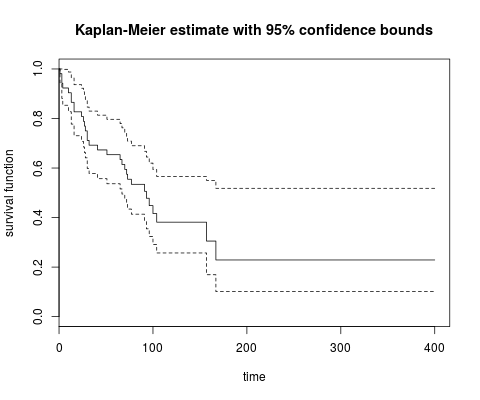

In [20]:
%%R -h 400
plot(surv.fit, main='Kaplan-Meier estimate with 95% confidence bounds',
     xlab='time', ylab='survival function')

Let's convert this plot into an interactive [plotly](https://plot.ly/) object using plotly and [ggplot2](http://ggplot2.org/).

First, we will use a helper ggplot function written by [Edwin Thoen](https://www.r-statistics.com/2013/07/creating-good-looking-survival-curves-the-ggsurv-function/) to plot pretty survival distributions in R.

In [21]:
%%R

ggsurv <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                   cens.col = 'red', lty.est = 1, lty.ci = 2,
                   cens.shape = 3, back.white = F, xlab = 'Time',
                   ylab = 'Survival', main = ''){
 
  library(ggplot2)
  strata <- ifelse(is.null(s$strata) ==T, 1, length(s$strata))
  stopifnot(length(surv.col) == 1 | length(surv.col) == strata)
  stopifnot(length(lty.est) == 1 | length(lty.est) == strata)
 
  ggsurv.s <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                       cens.col = 'red', lty.est = 1, lty.ci = 2,
                       cens.shape = 3, back.white = F, xlab = 'Time',
                       ylab = 'Survival', main = ''){
 
    dat <- data.frame(time = c(0, s$time),
                      surv = c(1, s$surv),
                      up = c(1, s$upper),
                      low = c(1, s$lower),
                      cens = c(0, s$n.censor))
    dat.cens <- subset(dat, cens != 0)
 
    col <- ifelse(surv.col == 'gg.def', 'black', surv.col)
 
    pl <- ggplot(dat, aes(x = time, y = surv)) +
      xlab(xlab) + ylab(ylab) + ggtitle(main) +
      geom_step(col = col, lty = lty.est)
 
    pl <- if(CI == T | CI == 'def') {
      pl + geom_step(aes(y = up), color = col, lty = lty.ci) +
        geom_step(aes(y = low), color = col, lty = lty.ci)
    } else (pl)
 
    pl <- if(plot.cens == T & length(dat.cens) > 0){
      pl + geom_point(data = dat.cens, aes(y = surv), shape = cens.shape,
                       col = cens.col)
    } else if (plot.cens == T & length(dat.cens) == 0){
      stop ('There are no censored observations')
    } else(pl)
 
    pl <- if(back.white == T) {pl + theme_bw()
    } else (pl)
    pl
  }
 
  ggsurv.m <- function(s, CI = 'def', plot.cens = T, surv.col = 'gg.def',
                       cens.col = 'red', lty.est = 1, lty.ci = 2,
                       cens.shape = 3, back.white = F, xlab = 'Time',
                       ylab = 'Survival', main = '') {
    n <- s$strata
 
    groups <- factor(unlist(strsplit(names
                                     (s$strata), '='))[seq(2, 2*strata, by = 2)])
    gr.name <-  unlist(strsplit(names(s$strata), '='))[1]
    gr.df <- vector('list', strata)
    ind <- vector('list', strata)
    n.ind <- c(0,n); n.ind <- cumsum(n.ind)
    for(i in 1:strata) ind[[i]] <- (n.ind[i]+1):n.ind[i+1]
 
    for(i in 1:strata){
      gr.df[[i]] <- data.frame(
        time = c(0, s$time[ ind[[i]] ]),
        surv = c(1, s$surv[ ind[[i]] ]),
        up = c(1, s$upper[ ind[[i]] ]),
        low = c(1, s$lower[ ind[[i]] ]),
        cens = c(0, s$n.censor[ ind[[i]] ]),
        group = rep(groups[i], n[i] + 1))
    }
 
    dat <- do.call(rbind, gr.df)
    dat.cens <- subset(dat, cens != 0)
 
    pl <- ggplot(dat, aes(x = time, y = surv, group = group)) +
      xlab(xlab) + ylab(ylab) + ggtitle(main) +
      geom_step(aes(col = group, lty = group))
 
    col <- if(length(surv.col == 1)){
      scale_colour_manual(name = gr.name, values = rep(surv.col, strata))
    } else{
      scale_colour_manual(name = gr.name, values = surv.col)
    }
 
    pl <- if(surv.col[1] != 'gg.def'){
      pl + col
    } else {pl + scale_colour_discrete(name = gr.name)}
 
    line <- if(length(lty.est) == 1){
      scale_linetype_manual(name = gr.name, values = rep(lty.est, strata))
    } else {scale_linetype_manual(name = gr.name, values = lty.est)}
 
    pl <- pl + line
 
    pl <- if(CI == T) {
      if(length(surv.col) > 1 && length(lty.est) > 1){
        stop('Either surv.col or lty.est should be of length 1 in order
             to plot 95% CI with multiple strata')
      }else if((length(surv.col) > 1 | surv.col == 'gg.def')[1]){
        pl + geom_step(aes(y = up, color = group), lty = lty.ci) +
          geom_step(aes(y = low, color = group), lty = lty.ci)
      } else{pl +  geom_step(aes(y = up, lty = group), col = surv.col) +
               geom_step(aes(y = low,lty = group), col = surv.col)}
    } else {pl}
 
 
    pl <- if(plot.cens == T & length(dat.cens) > 0){
      pl + geom_point(data = dat.cens, aes(y = surv), shape = cens.shape,
                      col = cens.col)
    } else if (plot.cens == T & length(dat.cens) == 0){
      stop ('There are no censored observations')
    } else(pl)
 
    pl <- if(back.white == T) {pl + theme_bw()
    } else (pl)
    pl
  }
  pl <- if(strata == 1) {ggsurv.s(s, CI , plot.cens, surv.col ,
                                  cens.col, lty.est, lty.ci,
                                  cens.shape, back.white, xlab,
                                  ylab, main)
  } else {ggsurv.m(s, CI, plot.cens, surv.col ,
                   cens.col, lty.est, lty.ci,
                   cens.shape, back.white, xlab,
                   ylab, main)}
  pl
}

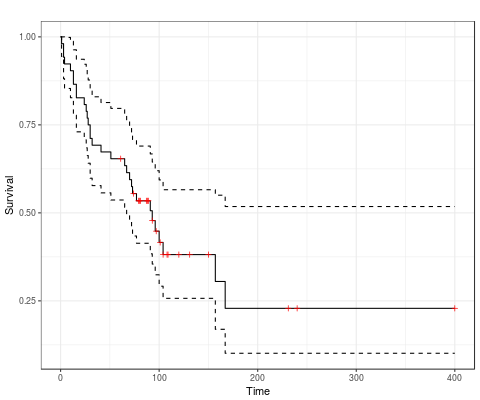

In [22]:
%%R -h 400
p <- ggsurv(surv.fit) + theme_bw()
p

The `y-axis` represents the probability a patient is still alive at time t weeks. We see a steep drop off within the first 100 weeks, and then observe the curve flattening. The dotted lines represent the 95% confidence intervals.

### Using Python

We will now replicate the above steps using python. Above, we have already specified a variable tongues that holds the data in a pandas dataframe.

In [23]:
from lifelines.estimation import KaplanMeierFitter
kmf = KaplanMeierFitter()

The method takes the same parameters as it's R counterpart, a time vector and a vector indicating which observations are observed or censored. 

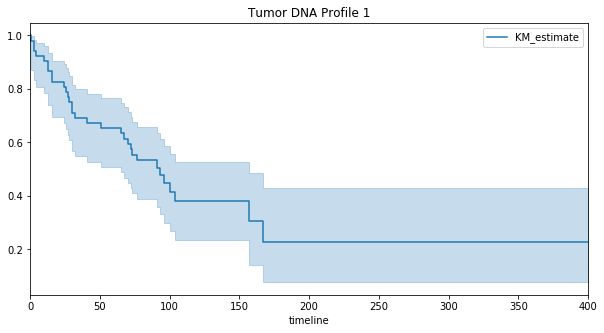

In [24]:
f = tongue.type==1
T = tongue[f]['time']
C = tongue[f]['delta']

kmf.fit(T, event_observed=C)
kmf.plot(title='Tumor DNA Profile 1')

Now we can convert this plot to an interactive [Plotly](https://plot.ly/) object. However, we will have to augment the legend and filled area manually. Once we create a helper function, the process is simple.

Please see the Plotly Python [user guide](https://plot.ly/python/overview/#in-%5B37%5D) for more insight on how to update plot parameters.

> We can also easily edit the chart properties using the Plotly GUI interface by clicking the "Play with this data!" link below the chart.

In [49]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

p = kmf.plot(ci_force_lines=True, title='Tumor DNA Profile 1 (95% CI)')

# Collect the plot object
kmf1 = plt.gcf() 

def pyplot(fig, ci=True, legend=True):
    """
    Convert mpl fig obj to plotly fig obj, resize to plotly's default
    Plotly opens (offline) in new window
    """
    
    py_fig = tls.mpl_to_plotly(fig, resize=True)
    
    # Add fill property to lower limit line
    if ci == True:
        style1 = dict(fill='tonexty')
        # apply style
        py_fig['data'][2].update(style1)
        
        # Change color scheme to black
        py_fig['data'].update(dict(line=Line(color='black')))
    
    # change the default line type to 'step'
    py_fig['data'].update(dict(line=Line(shape='hv')))
    # Delete misplaced legend annotations 
    py_fig['layout'].pop('annotations', None)
    
    if legend == True:
        # Add legend, place it at the top right corner of the plot
        py_fig['layout'].update(
            showlegend=True,
            legend=Legend(
                x=1.05,
                y=1
            )
        )
        
    # Send updated figure object to Plotly, show result in notebook
    return plot(py_fig)

init_notebook_mode(connected=True)
pyplot(kmf1, legend=False)

'file:///home/alvaro/Documentos/Analytics/Survival/temp-plot.html'

## Multiple Types

### Using R

Many times there are different groups contained in a single dataset. These may represent categories such as treatment groups, different species, or different manufacturing techniques. The type variable in the tongues dataset describes a patients DNA profile. Below we define a Kaplan-Meier estimate for each of these groups in R and Python.

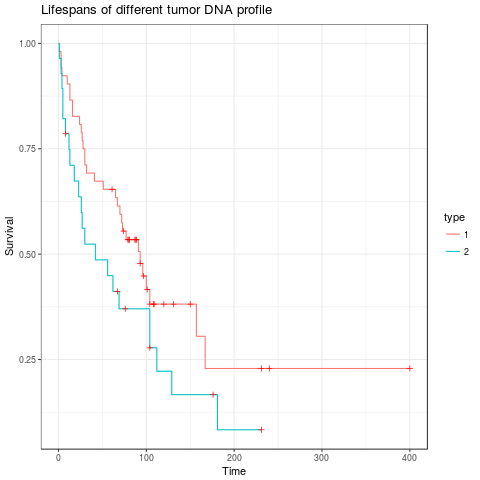

In [55]:
%%R

surv.fit2 <- survfit( Surv(time, delta) ~ type)

p <- ggsurv(surv.fit2) + ggtitle('Lifespans of different tumor DNA profile') + theme_bw()

p

### Using Python

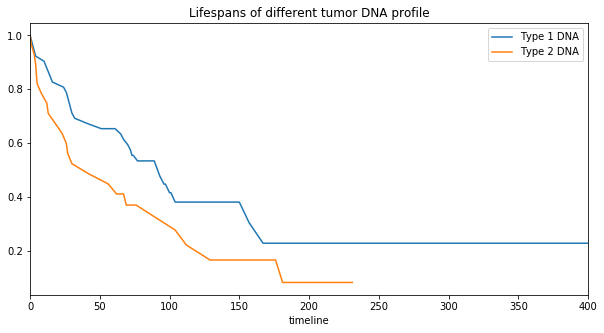

In [60]:
f2 = tongue.type==2
T2 = tongue[f2]['time']
C2 = tongue[f2]['delta']

ax = plt.subplot(111)

kmf.fit(T, event_observed=C, label=['Type 1 DNA'])
kmf.survival_function_.plot(ax=ax)
kmf.fit(T2, event_observed=C2, label=['Type 2 DNA'])
kmf.survival_function_.plot(ax=ax)

plt.title('Lifespans of different tumor DNA profile')

kmf2 = plt.gcf()

Convert to a Plotly object:

In [62]:
pyplot(kmf2, ci=False)

'file:///home/alvaro/Documentos/Analytics/Survival/temp-plot.html'

## Testing for Difference

It looks like DNA Type 2 is potentially more deadly, or more difficult to treat compared to Type 1. However, the difference between these survival curves still does not seem dramatic. It will be useful to perform a statistical test on the different DNA profiles to see if their survival rates are significantly different.

Python's `lifelines` contains methods in `lifelines.statistics`, and the R package `survival` uses a function `survdiff()`. Both functions return a p-value from a chi-squared distribution.

It turns out these two DNA types do not have significantly different survival rates.

### Using R

In [63]:
%%R 
survdiff(Surv(time, delta) ~ type)

Call:
survdiff(formula = Surv(time, delta) ~ type)

        N Observed Expected (O-E)^2/E (O-E)^2/V
type=1 52       31     36.6     0.843      2.79
type=2 28       22     16.4     1.873      2.79

 Chisq= 2.8  on 1 degrees of freedom, p= 0.0949 


### Using Python

In [66]:
from lifelines.statistics import logrank_test
summary_= logrank_test(T, T2, C, C2, alpha=0.99)

print summary_

<lifelines.StatisticalResult: 
Results
   df: 1
   alpha: 0.99
   t 0: -1
   test: logrank
   null distribution: chi squared

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.09487 |              2.790 |  Cannot Reject Null |       False       
>


## Estimating Hazard Rates

### Using R

To estimate the hazard function, we compute the cumulative hazard function using the [Nelson-Aalen estimator](https://plot.ly/ipython-notebooks/survival-analysis-r-vs-python/), defined as:

$$
\begin{eqnarray}
\hat \Lambda (t) = \sum_{t_i\leq t}\frac{d_i}{n_i}
\end{eqnarray}
$$

where $d_i$ is the number of deaths at time $t_i$ and $n_i$ is the number of susceptible individuals. Both R and Python modules use the same estimator. However, in R we will use the $-\log$ of the *Fleming and Harrington* estimator, which is equivalent to the *Nelson-Aalen*.

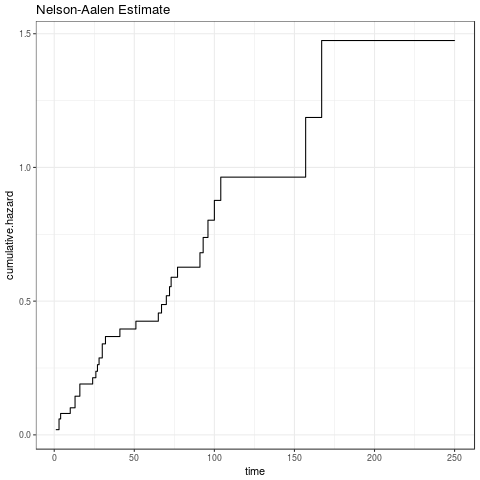

In [67]:
%%R  

haz <- Surv(time[type==1], delta[type==1])
haz.fit  <- summary(survfit(haz ~ 1), type='fh')

x <- c(haz.fit$time, 250)
y <- c(-log(haz.fit$surv), 1.474)
cum.haz <- data.frame(time=x, cumulative.hazard=y)

p <- ggplot(cum.haz, aes(time, cumulative.hazard)) + geom_step() + theme_bw() + 
        ggtitle('Nelson-Aalen Estimate')
p

### Using Python

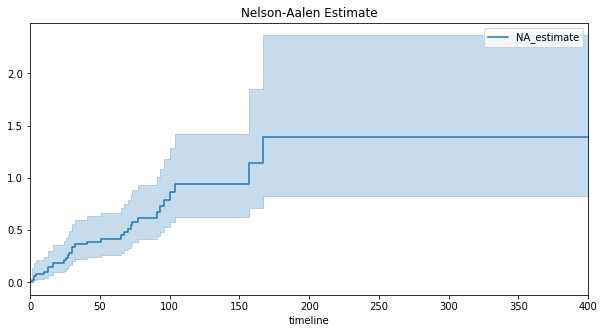

In [68]:
from lifelines.estimation import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(T, event_observed=C)

naf.plot(title='Nelson-Aalen Estimate')

In [69]:
naf.plot(ci_force_lines=True, title='Nelson-Aalen Estimate')
py_p = plt.gcf()

pyplot(py_p, legend=False)

'file:///home/alvaro/Documentos/Analytics/Survival/temp-plot.html'